## Info:  Pipeline
Eine Pipeline besteht aus mehreren Komponenten, welche alle jeweils den Output der vorherigen Komponente weiterverarbeiten und wieder an die nächste Komponente weitergeben. Dieser Prozess läuft normalerweise asynchron.  
Fällt eine Komponente aus, so kann das System trotzdem noch eine Weile mit den alten Outputs der ausgefallenen Komponente weiterarbeiten. Dies macht die Pipeline robust, allerdings können bei einer schlechten Überwachung solche Fehler lang unbemerk bleiben.

# Projekt
## 1. Aufgabe abstecken
* Ziel ist des den mittleren Immobilienpreis eines Bezirks aufgrund von versch. Merkmalen vorherzusagen.
* Der Output wird an eine nächste Komponente in einer ML-Pipeline weitergegeben, welche abschätzt, ob sich Investitionen in einem Bezirk lohnen.
    * Die Leistung wirkt sich also direkt auf den Geschäftsgewinn aus.
* Überwachtes Lernen, -> die Daten gelabelt sind.
* Regression -> Zahlenwerte vorhersagen
    * multivariate Regression -> mehrere Merkmale
* Batch learning -> kleiner Datensatz, keine sich laufend ändernde Daten
* 

## Info:  Qualitätsmass
> RMSE -> Wurzel der mittleren quadratischen Abweichung. Entspricht der Grösse des Fehlers, den das System im Mittle bei Vorhersagen macht.  

$\left(RMSE(X, h)\right) =\sqrt{\frac{1}{m}\sum_{i=1}^m\left(h(x^{(i)})-y^{(i)}\right)}$



## Info: Schreibweisen
* $m$ ist die Anzahl der Datenpunkte
* $x^{(i)}$ der i-te Datenpunkt eines Datensatzes ohne Label, ist ein Vektor.
* $y^{(i)}$ das i-te Label eines Datensatzes
* $X$ Matrix mit den Werten aller Merkmale(ohne Label) sämtlicher Datenpunkte im Datensatz
    * Pro Datenpunkt eine Zeile mit der transponierten Form von $x^{(i)}$
* $h$ ist die Funktion(Vorhersagefunktion), auch Hypothese genannt
* $\hat{\textbf{y}}^{(i)}$ ist das Resultat aus $h(x^{(i)})$

## 2. Dateien Herunterladen

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

DOWNLOAD_ROOT = 'https://github.com/ageron/handson-ml/raw/master/'
HOUSING_PATH = 'datasets/housing/'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + 'housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Daten herunterladen und entpacken"""
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        pass
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    pass

def load_housing_data(housing_path=HOUSING_PATH):
    """CSV als Pandas DataFrame laden."""
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

#fetch_housing_data()
housing = load_housing_data()

In [2]:
# die ersten zeilen
housing.head()
# beschreibung jeder spalte und des gesamten Frames
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
# zählt alle kategorien und die anzahl vorkommnisse
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
# zusammenfassung der numerischen werte
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
# histogramm jeder numerischen spalte
# vertikal(anzahl datenpunkte)
# horizontal(wertebereich)
# -> anzahl datenpunkte die einem wertebereich entsprechen

# bins -> dicke der balken
# figsize -> breite - x, höhe - y (im verhältnis zueinander??)

# housing.hist(bins=50, figsize=(20,15))
# plt.show()

## 3. Daten aufbereiten (Test/Training)

In [7]:
import numpy as np

In [8]:
def split_train_test(data, test_ratio):
    """pickt einen testsatz aus den trainigsdaten data"""
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), 'Training +', len(test_set), 'Test')

16512 Training + 4128 Test


In [9]:
import hashlib

In [10]:
def test_set_check(identifier, test_ratio, hash):
    """errechnet den hash des letzten bytes und gibt true/false zurück falls der hash grösser/kleiner 256 * prozent-testdaten zurück"""
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    """spaltet die daten anhand der test_set_check methode in test und trainingsdaten"""
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # fügt spalte index hinzu
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

## Info: Probleme beim Abspalten eines Testdatensatz
Man sollte keinen Einblick in die Testedaten haben, daher ist es wichtig, dass man die Testdaten früh von den Traininsdaten trennt. Ein sogenanntes **Data Snooping-Bias** wird dadurch verhindert.

### Data Snooping-Bias
>Bias: durch falsche Untersuchungsmethoden (z. B. Suggestivfragen) verursachte Verzerrung des Ergebnisses einer Repräsentativerhebung. (duden.de)  

Würde man die Daten mit den Testdaten zusammen untersuchen, so würde man unbewusst Muster erkennen, welche einen später bei der Wahl des Algorithmus beeinflussen können. Dadurch könnte die Leistung des Systems geschwächt werden.

### Stichproben-Bias
Dies ist eine Verzerrung durch falsch gewählte/erhobene Stichproben. Wenn nur ein **kleiner Datensatz** zur Verfügung steht ist die zufallsbasierte Strichprobenwahl riskant, da die Stichprobe **nicht repräsentativ** sein muss. 

Das gleiche kann sowohl bei der zufälligen Auswahl von Test/Trainingsdaten sowie auch bei der zufälligen Auswahl von Personen zum Befragen während der Erhebung der Daten.

### Strata
Eine **stratifizierte Stichprobe** ist eine Stichprobe, welche die Gesamtbevölkerung korrekt repräsentiert.
Die Bevölkerung wird dazu ein homogene Untergruppen aufgeteilt, dies sind sogenannte **Strata**.  

**Stichproben-Bias** ist verhindert, wenn die Stichprobe stratifiziert ist.  
Es sollte nicht zu viele Strate geben und jedes Strata sollte gross genug sein, sprich genügend Datenpunkte enthält.

### Bias für Schätzung der Wichtigkeit des Stratums

Wenn nicht jedes Stratum genügen Datenpunkte enthält, so werden die Strata falsch gewichtet, sprich bekommen eine falsche Wichtigkeit.

### Wahl der Testdaten
**Zufällige auswahl**
>**20%** aller Daten, trennen mit train_test_split von sklearn.model_selection

**stratifizierte Auswahl**
>**20%** aller Daten, trennen mit StratifiedShuffleSplit von sklearn.model_selection

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
#teile die einkommen in kategorien ein. erst geteilt durch 1.5 um die Anzahl kategorien zu begrenzen
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
# ersetze alle über 5 mit 5
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [13]:
# aufteilung in trainings- und testdaten mit sklearn
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

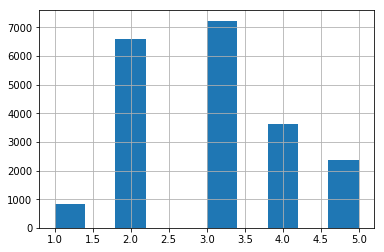

In [14]:
# die kategorien visualisieren
housing['income_cat'].hist()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
# spliter konfigurieren
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# eine stratifizierte strichprobe als testdaten generieren lassen.
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    pass

In [17]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 11 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.5+ MB


In [18]:
# kontrollieren ob die ausgewählten daten tatsächlich den gesamten Datensatz repsäsentieren
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [19]:
# die stratifizierten Daten repräsentieren die gesamten daten sehr genau
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [20]:
# hier gibt es bereits grössere abweichungen
test_set['income_cat'].value_counts() / len(test_set)

3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

In [21]:
# income_cat löschen um die ursprünglichen daten zu erhalten
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## 4. Daten erkunden und visualisieren

In [22]:
# trainingsdaten kopieren um sie nicht zu beschädigen
# falls der Trainingsdatensatz sehr gross ist, so könnte man hier auch nur eine stichprobe verwenden um alles zu beschleunigen
housing = strat_train_set.copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


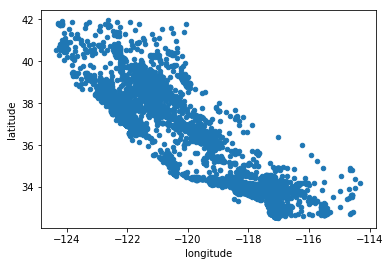

In [23]:
# geografische daten visualisieren
housing.plot(kind='scatter', x='longitude', y='latitude')

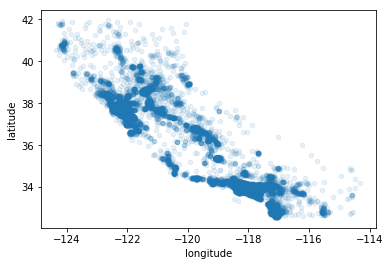

In [24]:
# alpha auf 0.1,damit die punktstärke unterschiedlich ist
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

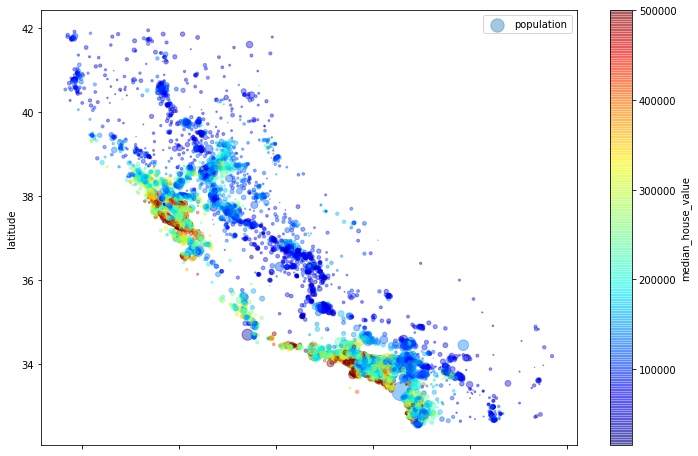

In [25]:
# radius der Punkte -> bevölkerung eines bezirks / 100 -> option s
# farbe der punkte -> häuser preis -> option c
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population'] / 100
            , label='population', figsize=(12,8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

## Info: Korrelationen
Die Korrelation misst die **Stärke einer Beziehung zwischen zwei Variablen**.
Der **Korrelationseffizient** hat einen Wert zwischen 1 und -1.  
* nahe 1
    * je grösser $a$ desto grösser $b$
    * starke positive Korrelation
* nahe -1
    * je grösser $a$ desto kleiner $b$
    * starke negative Korrelation
* nahe 0
    * keine Beziehung zueinander
    * keine Korrelation
    
Der Korrelationseffizient erfasst ausschliesslich lineare Korrelationen. Nichtlineare Beziehungen/Zusammenhänge werden nicht erkannt.

In [26]:
# korrelationskoeffizienten berechnen
corr_matrix = housing.corr()

In [27]:
# anzeigen der koeffizienten
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [28]:
from pandas.plotting import scatter_matrix

In [29]:
# die vielversprechendsten merkmale gegenainander auftragen
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

# scatter_matrix(housing[attributes], figsize=(12,8))

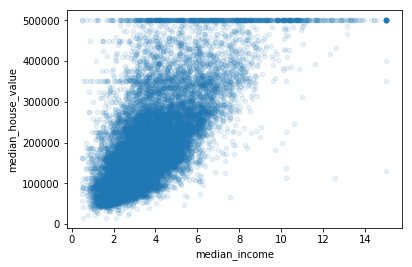

In [30]:
# den höchsten korrelationskoeffizienten hat median_income
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [31]:
# auf 500k, 450k, 350k gibt es horizontale linien, welche evt vor dem ML entfernt werden sollten.

## Info: Kombination von Merkmalen

In [32]:
# räume pro haushalt
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
# wieviel räume sind schlafzimmer
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
# einwohner pro haushalt
housing['population_per_household'] = housing['population'] / housing['households']

In [33]:
# korrelationen neu berechnen
corr_matrix = housing.corr()

In [34]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [35]:
attributes = ['median_house_value', 'median_income', 'rooms_per_household', 'bedrooms_per_room']
# scatter_matrix(housing[attributes], figsize=(12,8))

In [36]:
# labels entfernen und kopie der trainingsdaten
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## 5. Aufbereiten der Daten
Da ML-Algorithmen nicht mit fehlenden Daten umgehen können muss man diese bearbeiten. dazu hat man 3 Möglichkeiten:  
1. die unvollständigen Datensätze entfernen
* die unvollständigen Merkmale entfernen
* die fehlende Werte auf einen bestimmten Wert setzen
    * etwa der Median oder $0$

In [37]:
# 1
housing.dropna(subset=['total_bedrooms'])
# 2
housing.drop('total_bedrooms', axis=1)
# 3
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

**Wichtig:**  
Der Wert, welcher die fehlenden Werte in Möglichkeit 3. ersetzte muss vermerkt sein, da in den Testdaten und in neuen Daten auch fehlende Werte vorhanden sein könnten.

**Imputer** ist eine Klasse von sklearn um fehlende Werte zu bearbeiten.

In [38]:
from sklearn.preprocessing import Imputer

In [39]:
# imputer mit der strategy median erzeugen
imputer = Imputer(strategy='median')

In [40]:
# der imputer kann nur mit numerischen werten umgehen
housing_num = housing.drop('ocean_proximity', axis=1)

In [41]:
# imputer an daten anpassen
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [42]:
# die angepassten daten
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [43]:
# kontrolle ob alles stimmt
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [44]:
# fehlende ersetzen -> transformieren
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Design von SciKit-Learn
### Konsistenz
#### Estimatoren / Schätzer
> Jedes Objekt, das Parameter anhand eines Datensatzes abschätzen kann, wird Estimator genannt.  

Alle Objekte die von Daten lernen sind Estimatoren, z.B.:
* Classification
* Regression
* Clustering
* Transformer
    * Extrahiert/Filtert nützliche Eigenschaften aus rohen Daten

**fit()**: Abschätzen der Parameter

#### Transformer

Estimatoren, welche einen Datensatz transformieren können werden Transformatoren genannt.  

Arten von Transformationen:
* clean
    * reinigen
* reduce
    * reduzieren
* expand
    * erweitern
* generate
    * generieren

**fit()**: Abschätzen der Parameter  
**transform()**: Anwenden der Transformation auf einen Datensatz  
**fit_transform()**: Beide Schritte nacheinander -> für mehr Lerformance  

#### Prädikatoren

Estimatoren, welche auf einen gegebenen Datensatz Vorhersagen treffen können.  

**fit()**: Abschätzen der Parameter  
**predict()**: Vorhersagen eines entsprechenden Wertes auf einen Datensatz  
**score()**: Bestimmen der Vorhersagequalität mit einem Testdatensatz  

### Inspektion
Alle Hyperparameter sind als öffentliche Attribute der Instanz abrufbar.
Alle erlernten Parameter sind als öffentliche Attribute mit dem suffix _ abrufbar.
Alle Hyperparameter können dem Konstuktor mitgegeben werden.  

### Nicht-proliferierende Klassen
Datensätze sind gewöhnlich np-Arrays oder Sci-Py Sparse Matrices. Hyperparameter sind Strings oder Zahlen.  

### Komposition
Existierende Komponenten können etwa in **Pipeline**s als beliebige Abfolge von Transformatoren mit einem Estimator wiederverwendet werden.  

### Sinvolle Standardwerte
Die Standardwerte sind meistens so gewählt, dass man möglichst wenig Anpassen muss um ein lauffähiges Grundsystem erstellen zu können.  



## 6. Bearbeiten von Text und kategorischen Merkmalen
Die meisten ML-Algorithmen bevorzugen Zahlen anstatt andere Datentypen.  
Aus diesem Grund sollten alle nicht numerischen Merkmale numerisch gemacht werden.  
Die einfachste Möglichkeit ist es, alle verschiedenen Werte in einer Kategorien Liste abzuspeichern und den Wert des Merkmals mit dem Index aus der Kategorien-Liste zu ersetzten.  
Die funtkioniert aber nicht, da viele ML-Algorithmen zahlen so interpretieren, dass die Zahlen 1 und 2 mehr Gemeinsamkeiten/Nähe hätten als die Zahlen 1 und 34.  
Dies würde bei den Index der Kategorie nicht zutreffen.  

### OneHotEncoding
Dies ist die Lösung auf oben dargestelltes Problem.  
Für jede Kategorie wird eine Spalte hinzugefügt. Die Werte der Spalten sind entweder 1 oder 0.

In [45]:
housing_cat = housing['ocean_proximity']
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [46]:
# Die meisten ML-Algorithmen bevorzugen nur zahlen
housing_cat_encoded, housing_categories = housing_cat.factorize()
for enc in housing_cat_encoded[:5]:
    print(housing_categories[enc])

<1H OCEAN
<1H OCEAN
NEAR OCEAN
INLAND
<1H OCEAN


In [47]:
from sklearn.preprocessing import OneHotEncoder

In [48]:
encoder = OneHotEncoder()

In [49]:
# in das OneHot format umwandeln.
# der encoder erwartet ein 2D-array, daher np.reshape(-1,1)
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [50]:
# vom sparsamen sparse matrix nach np-Array umwandeln
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [51]:
# Neu ab sklearn > 19:
# CategoricalEncoder -> übernimmt beide schritte auf einmal
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [52]:
cat_encoder = CategoricalEncoder()
# die dimension ändern
housing_cat_reshaped = housing_cat.values.reshape(-1,1)
# 
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [53]:
# für ein dichtes np-Array anstatt eine sparse matrix
cat_encoder = CategoricalEncoder(encoding='onehot-dense')
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [54]:
for i in housing_cat_1hot[:5]:
    print(cat_encoder.categories_[0][int(i[0])])

INLAND
INLAND
<1H OCEAN
<1H OCEAN
INLAND


In [55]:
# alle kategorien
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

## Eigene Transformer
### Duck-Typing
SciKit-Learn verwendet Duck-Typing anstatt Vererbung. Es ist zu vergleichen mit Interfaces in Java, denn es wird sichergestellt, das die Klasse die benötigten Methoden hat, anstatt mit Vererbung/Interfaces die Methoden zu erben und implementieren.
### CustomTransformer
Um eigene Transformer zu schreiben, braucht man also nur die Nötigen Methoden zu implementieren. BaseEstimator bietet die Methoden get/set_params() und TransormerMixin bietet die Methode fit_transformer(). Ich muss daher noch fit() und transform() implementieren.  

Eigene Transformer welche der Architektur von sklearn-transformern entsprechen könne auch in Pipelines eingebunden werden.

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

In [57]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, population_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [58]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
#housing_extra_attribs = attr_adder.
housing_extra_attribs = attr_adder.transform(housing.values)

## Skalieren von Merkmalen
Das Skalieren der Merkmale ist sehr wichtig, da viele ML-Algorithmen nicht mit Eingabedaten von unterschiedlichen Skalen arbeiten können.
### Min-Max-Skalierung (Normalisieren)
Die Werte werden so verschoben und umskaliert, dass die Werte danach von **0 bis 1** reichen.
**Vorgehen**:
* Kleinster Wert abziehen
* Durch die Differenz von Minimal- und Maximalwert teilen

**Transformator**:
MinMaxScaler  
### Standardisierung
Die Werte werden so umskaliert, dass die Werte danach eine **Varianz von 1** hat.  
Mit der Standardisierung ist man nicht an einen bestimmten Wertebereich gebunden.
**Vorgehen**:
* Mittelwert/Durchschnitt subtrahieren = $m$
* Varianz berechnen $v = \frac{(x_1-m)^2+(x_n-m)^2}{n}$
* Durch die Varianz teilen

**Transformator**: StandardScaler

## Pipelines zur Transformation

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [60]:
num_pipeline = Pipeline([
    ('inputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [61]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.08649871,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.03353391,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.09240499,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ..., -0.03055414,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.06150916,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.09586294,
        -0.09586294,  0.10180567]])

In [62]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values

In [63]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [64]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('categorical_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

In [65]:
from sklearn.pipeline import FeatureUnion

In [66]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [67]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# 7. LinearRegression

In [68]:
from sklearn.linear_model import LinearRegression

In [69]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## 7.1. Testen (mit Trainingsdaten)

In [70]:
# 10 Datensätze vorhersagen und mit Labels vergleichen
some_data_prepared = housing_prepared[:10]
print('Vorhersage', lin_reg.predict(some_data_prepared))
print('Label', housing_labels[:10].values)

Vorhersage [ 210563.33661755  318260.76438827  211215.14630977   59114.79474222
  187121.77956263  154877.14429632  425018.6147059   228863.49556853
  139487.09128282   30369.97010676]
Label [ 286600.  340600.  196900.   46300.  254500.  127900.  500001.  140200.
   95000.  500001.]


## 7.2. Fehler berechnen

In [71]:
from sklearn.metrics import mean_squared_error

In [72]:
# den fehler berehcnen mit allen trainingsdaten
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68826.635850955645

# 8. Trainieren mit DecisionTreeRegressor

In [73]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## 8.1. Fehler berechnen

In [75]:
# den fehler berehcnen mit allen trainingsdaten
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# 9. Kreuzvalidierung

In [76]:
from sklearn.model_selection import cross_val_score

## 9.1. DecisionTreeRegression

In [77]:
# mithilfe von kreuzvalidieerung den ML-Algorithmus mit kleinen Trainingsdatensätzen trainieren
# und mit einem noch kleineren Testen/Validieren
# cv ist die anzahl von kreuzvalidierungen
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
# hier wird -scores verwendet, da sklearn eine Nutzenfunktion erwartet, wir aber eine Kostenfunktion haben.
tree_rmse_scores = np.sqrt(-scores)

In [78]:
def display_scores(scores):
    print('scores:',scores)
    print('Mittelwert:', scores.mean())
    print('Standardabweichung:', scores.std())

In [79]:
display_scores(tree_rmse_scores)

scores: [ 67614.1575432   69118.71692926  70812.76137555  69190.91650988
  70615.74987998  75467.87584127  72568.88054741  70585.30400708
  74200.16818044  71511.15572933]
Mittelwert: 71168.5686543
Standardabweichung: 2264.3347983


## 9.2. LinearRegression

In [80]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [81]:
display_scores(lin_rmse_scores)

scores: [ 66899.81050358  67175.37517063  70150.13267841  74996.34376617
  67805.64981263  71294.59349397  65186.40759905  68217.48595344
  72578.14406325  67736.06602734]
Mittelwert: 69204.0009068
Standardabweichung: 2843.42966609


## 9.3 RandomForestRegression

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [83]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [85]:
display_scores(forest_rmse_scores)

scores: [ 52473.09839637  50761.01585339  52474.91242239  54076.13441134
  51845.24038687  56614.00891572  51699.17111149  50755.02350027
  54054.22406051  53506.34684486]
Mittelwert: 52825.9175903
Standardabweichung: 1700.46439763


# 10. Modell speichern

In [86]:
from sklearn.externals import joblib

In [87]:
joblib.dump(forest_reg, os.path.join('models/chapter2','forest_reg.pkl'))

['models/chapter2/forest_reg.pkl']

In [88]:
forest_reg = joblib.load(os.path.join('models/chapter2','forest_reg.pkl'))

In [89]:
forest_reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [90]:
def save(model, filename):
    joblib.dump(model, os.path.join('models/chapter2', filename))
    pass

In [91]:
save(forest_reg, 'forest_reg.pkl')
save(lin_reg, 'lin_reg.pkl')
save(tree_reg, 'tree_reg.pkl')


# 11. Modell optimieren
Mit GridSearch werden verschiedene Parameterkombinationen ausprobiert und die beste wird evaluiert.
Noch besser geht RandomizedSearchCV vor, dieser probiert soviele veschiedene zufällige kombinationen aus wie man will.

In [92]:
# mit grid search cross validation
from sklearn.model_selection import GridSearchCV

In [93]:
param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor()
# finde die beste Parameter kombination
# refit -> trainiert den Besten Estimator nochmals mit allen Trainigsdaten
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [94]:
best_forest_reg = grid_search.best_estimator_
best_forest_params = grid_search.best_params_

In [95]:
best_forest_params

{'max_features': 6, 'n_estimators': 30}

In [96]:
save(best_forest_reg, 'best_forest_reg.pkl')

In [97]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64507.5884861 {'max_features': 2, 'n_estimators': 3}
54995.6385447 {'max_features': 2, 'n_estimators': 10}
53016.8284953 {'max_features': 2, 'n_estimators': 30}
60856.8899429 {'max_features': 4, 'n_estimators': 3}
53353.2201374 {'max_features': 4, 'n_estimators': 10}
50910.3201632 {'max_features': 4, 'n_estimators': 30}
59728.3632069 {'max_features': 6, 'n_estimators': 3}
52731.9437169 {'max_features': 6, 'n_estimators': 10}
50724.961967 {'max_features': 6, 'n_estimators': 30}
58567.3660411 {'max_features': 8, 'n_estimators': 3}
53274.8343108 {'max_features': 8, 'n_estimators': 10}
50869.5003837 {'max_features': 8, 'n_estimators': 30}
62793.6083566 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54717.7499925 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60044.528074 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52755.7995705 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59584.9348466 {'bootstrap': False, 'max_features': 4, 'n_estimat

In [98]:
from sklearn.model_selection import RandomizedSearchCV

# 14. SVM Regressor

In [99]:
from sklearn.svm import SVR

In [100]:
svm_reg = SVR(kernel='linear', C=2.0)
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [101]:
# mit kreuzvalidierung
# scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
# display_scores(np.sqrt(-scores))

scores: [ 100167.53797714  106450.96002723  104353.55143456  107445.13644918
  104771.63649628  110026.17888864  104705.95524646  108363.00211514
  108368.05548455  105941.95149252]
Mittelwert: 106059.396561
Standardabweichung: 2637.67495122


# finde die besten parameter
params = {
    'kernel':['linear', 'rbf','poly'],
    'C':[1.0, 2.0, 100, 200],
    'gamma':[0.1,0.5,1],
}
rand_svr = RandomizedSearchCV(svm_reg, params, cv=5, scoring='neg_mean_squared_error', refit=True)

rand_svr.fit(housing_prepared, housing_labels)

best_svr_reg = rand_svr.best_estimator_
best_svr_params = rand_svr.best_params_
print(best_svr_params)

cvres = rand_svr.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

# 13. Fehler des Modells evaluieren

In [102]:
feature_importances = best_forest_reg.feature_importances_

feature_importances

array([  6.76758789e-02,   6.71316151e-02,   4.51655267e-02,
         1.84542536e-02,   1.72245205e-02,   1.67865547e-02,
         1.69748355e-02,   3.45187995e-01,   5.89328163e-02,
         7.95979098e-02,   1.03796628e-01,   1.28418012e-02,
         1.41588985e-01,   9.23195584e-05,   4.06934087e-03,
         4.47901856e-03])

In [103]:
extra_attribs = ['rooms per hhold', 'pop_per_hhold', 'bedrooms_per_room']

cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
print(attributes)
sorted(zip(feature_importances, attributes), reverse=True)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms per hhold', 'pop_per_hhold', 'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


[(0.34518799544703632, 'median_income'),
 (0.14158898539691531, 'INLAND'),
 (0.10379662770036191, 'bedrooms_per_room'),
 (0.07959790984096414, 'pop_per_hhold'),
 (0.067675878889022364, 'longitude'),
 (0.06713161509744002, 'latitude'),
 (0.058932816339490261, 'rooms per hhold'),
 (0.045165526703408961, 'housing_median_age'),
 (0.018454253611068807, 'total_rooms'),
 (0.017224520530549951, 'total_bedrooms'),
 (0.016974835539580516, 'households'),
 (0.016786554665037822, 'population'),
 (0.01284180124689382, '<1H OCEAN'),
 (0.0044790185644903221, 'NEAR OCEAN'),
 (0.0040693408693621737, 'NEAR BAY'),
 (9.2319558377215201e-05, 'ISLAND')]

# 12. Evaluieren mit den Testdaten

In [104]:
final_model = best_forest_reg

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

# wichtig!! nur transform() aufrufen
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49019.944623648727

# Optimiere das Modell

## Gittersuche
Die Gittersuche probiert verschiedene Kombinationen von Parametern aus und evaluiert die beste Kombination mithilfe der Kreuzvalidierung.
## Zufällige Suche
Diese Suche ist sehr ähnlich zur Gittersuche, allerdings werden die Werte der Parameter hier zufällig gewählt und die anzahl Iterationen können festgelegt werden.
## Ensemble-Methoden
Hier werden Modelle mit der besten Leistung miteinander kombiniert. Dies verbessert die Leistung, da sich die verschiedenen Fehler der einzelnen Modelle zusammen ausgleichen.
## Analysiere die besten Modelle und ihre Fehler
Über das Attribut **feature\_importances_** kann man einsehen, welche Merkmale den grössten Einfluss auf das Modell haben. Somit kann man sehen, welche Merkmale entfernt werden können, oder ob noch mehr hinzugefügt werden sollen.
## Evaluiere das System auf dem Testdatensatz
Nachdem der Fehler mit dem Testdatensatz errechnet wurde, sieht man möglicherweise, dass das Modell auf den Trainingsdaten besset abschneidet, als bei der Kreuzvalidierung. Dies ist der Fall, wenn man die Hyperparameter zu sehr den Trainingsdaten angepasst hat. Man darf aber auf keinen Fall die Hyperparameter nochmals ändern, sonst stimmt die errechnete Leistung nicht überrein mit der Leistung auf neue Daten.  
### Präsentieren
Die Erkenntnise, der Ablauf, die Lösung etc. sollen dokumentiert, präsentiert und visualisiert werden!
## In Betrieb nehmen und Überwachen
hier weiterfahren, dann aufgaben

# Hier fortfahren im nächsten Notebook:
# 02_end_to_end_machine_learning_project_as_programm